Load final versions of datasets with adjustment from preliminary feature importance evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# Load final versions of datasets
df_final = pd.read_csv("datasets/churn_preprocessed_train_final.csv")

cols_state_area = df_final.columns[df_final.columns.str.contains('state|area_code')]

df_final_v3 = df_final.drop(columns=cols_state_area)
df_final_v3 = df_final_v3.drop(columns=['voice_mail_plan', 'intl_charge_per_min_cate'])

# df_final_v3.to_csv('churn_preprocessed_test_final.csv', index=False)

# define train dataset
X_train_final = df_final_v3.drop(columns=['churn'])
y_train_final = df_final_v3['churn']

# define holdout dataset
test_data_v3 = pd.read_csv('datasets/churn_preprocessed_test_final.csv')
X_test_final = test_data_v3.drop(columns=['churn'])
y_test_final = test_data_v3['churn']

In [4]:
from skopt import BayesSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report


from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from statistics import mean
from datetime import datetime

## Model Construction

### AutoML Screening

In [5]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.5+9-LTS-239, mixed mode, sharing)
  Starting server from C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ACER\AppData\Local\Temp\tmp6_vx4rw1
  JVM stdout: C:\Users\ACER\AppData\Local\Temp\tmp6_vx4rw1\h2o_ACER_started_from_python.out
  JVM stderr: C:\Users\ACER\AppData\Local\Temp\tmp6_vx4rw1\h2o_ACER_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Ho_Chi_Minh
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_ACER_gdgrkc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.914 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [6]:
automl_data = h2o.H2OFrame(pd.concat([X_train_final, y_train_final], axis=1))
automl_data["churn"] = automl_data["churn"].asfactor()

X_automl = pd.concat([X_train_final, y_train_final], axis=1).columns.drop('churn').tolist()
y_automl = "churn"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# Run H2O AutoML
aml = H2OAutoML(
    max_models=20,        
    seed=42, 
    max_runtime_secs=300,
    exclude_algos=["DeepLearning","StackedEnsemble"],
    nfolds=5
)
aml.train(x=X_automl, y=y_automl, training_frame=automl_data)
lb = aml.leaderboard
print(lb)

AutoML progress: |
11:41:15.222: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse        mse
GBM_grid_1_AutoML_1_20241205_114115_model_5   0.929914   0.156249  0.87293                0.104742   0.190809  0.0364081
GBM_3_AutoML_1_20241205_114115                0.926514   0.156696  0.871147               0.110775   0.192963  0.0372348
GBM_2_AutoML_1_20241205_114115                0.924049   0.157111  0.872566               0.116312   0.192969  0.0372371
GBM_4_AutoML_1_20241205_114115                0.923313   0.158048  0.872897               0.113954   0.19202   0.0368718
GBM_grid_1_AutoML_1_20241205_114115_model_8   0.923173   0.168464  0.858709               0.118287   0.199014  0.0396067
GBM_grid_1_AutoML_1_20241205_114115_model_9   0.921246   0.167945  0.869922               0.0956154  0.197843  0.039

In [8]:
aml.leader

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20241205_114115_model_5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    48                 48                          62951                  9            9            9             42            148           99.5625

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.004321964691827907
RMSE: 0.06574165111881437
LogLoss: 0.028217226777952804
Mean Per-Class Error: 0.0004389815627743635
AUC: 0.9999960401147687
AUCPR: 0.9999767450557524
Gini: 0.9999920802295375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24148554666126054
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      2276  2    0.0009   (2.0/2278.0)
1      0     388  0        (0.0/388.0)
Total  2276  390  0.0008   (2.0/2666.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.241486     0.997429  184
max f2                       0.241486     0.99897   184
max f0point5                 0.270416     0.998444  180
max accuracy                 0.263229     0.99925   183
max precision                0.993677     1         0
max recall                   0.241486     1         184
max specificity              0.993677     1         0
max absolute_mcc             0.241486     0.996995  184
max min_per_class_accuracy   0.241486     0.999122  184
max mean_per_class_accuracy  0.241486     0.999561  184
max tns                      0.993677     2278      0
max fns                      0.993677     387       0
max fps                      0.00245041   2278      399
max tps                      0.241486     388       184
max tnr                      0.993677     1         0
max fnr                      0.993677     0.997423  0
max fpr                      0.00245041   1         399
max tpr                      0.241486     1         184

Gains/Lift Table: Avg response rate: 14.55 %, avg score: 14.53 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0101275                   0.987157           6.87113  6.87113            1                0.989354    1                           0.989354            0.0695876       0.0695876                  587.113  587.113            0.0695876
2        0.0202551                   0.984677           6.87113  6.87113            1                0.985804    1                           0.987579            0.0695876       0.139175                   587.113  587.113            0.139175
3        0.0300075                   0.982031           6.87113  6.87113            1                0.98346     1                           0.986241            0.0670103       0.206186                   587.113  587.113            0.206186
4        0.040135                    0.980491           6.87113  6.87113            1                0.981334    1                           0.985003            0.0695876       0.275773                   587.113  587.113            0.275773
5        0.0502626                   0.978283           6.87113  6.87113            1                0.979488    1                           0.98389

In [31]:
# Cross validation sampling for training

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_split = cv.split(X_train_final, y_train_final)

### Base Models Building

In [32]:
# Calculate scale_pos_weight to handle class imbalance
negative_count_final = np.sum(y_train_final == 0)
positive_count_final = np.sum(y_train_final == 1)
scale_pos_weight_final = negative_count_final / positive_count_final

# Define parameter space for BayesSearchCV
param_space_lgbm_final = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5)
}

param_space_xgb_final = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5),
    'tree_method': ['auto']
}

param_space_cb_final = {
    'iterations': (100, 200),
    'depth': (3, 10),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255),
}

lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
cb_model = CatBoostClassifier(random_state=42)

model_list = {
    'cb': {'model': cb_model, 'params': param_space_cb_final},
    'lgbm': {'model': lgbm_model, 'params': param_space_lgbm_final},
    'xgb': {'model': xgb_model, 'params': param_space_xgb_final},

}

base_models_preds = {'index': [], 'model' : [], 'y_pred': [], 'y_pred_proba': []}
base_best_model = {model_name: None for model_name in model_list.keys()}
eval_metrics = {
    model_name: {"roc_auc_score": [], "accuracy_score": [], "f1_score": []}
    for model_name in model_list.keys()
}

# apply cross validation:
for i, (train_index, val_index) in enumerate(cv_split):
    X_train_cv, X_val_cv = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_cv, y_val_cv = y_train_final.iloc[train_index], y_train_final.iloc[val_index]
    for j, (model_name, model_info) in enumerate(model_list.items()):
        model = model_info['model']
        param_space = model_info['params']
        while True:
            if i == 0:
                X_train_base, X_val_base = X_train_cv.copy(), X_val_cv.copy()
                y_train_base, y_val_base = y_train_cv.copy(), y_val_cv.copy()
                if param_space:
                    print(f"Hyperparameter tuning for {model_name}...")
                    bayes_search_final = BayesSearchCV(
                        estimator=model,
                        search_spaces=param_space,
                        scoring='roc_auc',
                        n_jobs=-1,
                        verbose=0,
                        random_state=42
                    )
                    bayes_search_final.fit(X_train_cv, y_train_cv)
                    base_best_model[model_name] = bayes_search_final.best_estimator_
                else:
                    print(f"No hyperparameter tuning for {model_name}. Training default model...")
                    model.fit(X_train_cv, y_train_cv)
                    base_best_model[model_name] = model
                    
                print(f"Best estimator: {base_best_model[model_name]}")
                break
            else:
                break
        print(f"Model: {model_name}, Predicting for the {i+1} fold.")
        y_pred = base_best_model[model_name].predict(X_val_cv)
        y_pred_proba = base_best_model[model_name].predict_proba(X_val_cv)[:, 1]
        
        eval_metrics[model_name]["roc_auc_score"].append(roc_auc_score(y_val_cv, y_pred_proba))
        eval_metrics[model_name]["accuracy_score"].append(accuracy_score(y_val_cv, y_pred))
        eval_metrics[model_name]["f1_score"].append(f1_score(y_val_cv, y_pred))


        base_models_preds["index"].extend(val_index)
        base_models_preds["model"].extend([model_name]*len(val_index))
        base_models_preds["y_pred"].extend(y_pred)
        base_models_preds["y_pred_proba"].extend(y_pred_proba)

Hyperparameter tuning for cb...
0:	learn: 0.5899177	total: 1.49ms	remaining: 296ms
1:	learn: 0.5240018	total: 2.53ms	remaining: 251ms
2:	learn: 0.4748764	total: 3.51ms	remaining: 231ms
3:	learn: 0.4308419	total: 4.77ms	remaining: 234ms
4:	learn: 0.3921638	total: 6.02ms	remaining: 235ms
5:	learn: 0.3678397	total: 7.19ms	remaining: 232ms
6:	learn: 0.3458980	total: 8.35ms	remaining: 230ms
7:	learn: 0.3243606	total: 9.65ms	remaining: 232ms
8:	learn: 0.2994913	total: 10.8ms	remaining: 229ms
9:	learn: 0.2839616	total: 11.9ms	remaining: 226ms
10:	learn: 0.2737447	total: 13ms	remaining: 223ms
11:	learn: 0.2612820	total: 14ms	remaining: 220ms
12:	learn: 0.2504445	total: 15ms	remaining: 215ms
13:	learn: 0.2414669	total: 16ms	remaining: 212ms
14:	learn: 0.2371144	total: 17ms	remaining: 209ms
15:	learn: 0.2319211	total: 18ms	remaining: 207ms
16:	learn: 0.2259072	total: 19.9ms	remaining: 214ms
17:	learn: 0.2178206	total: 21ms	remaining: 213ms
18:	learn: 0.2122712	total: 22.1ms	remaining: 210ms
19:	

In [33]:
agg_eval_metrics = {model: {metric: np.mean(eval_metrics[model][metric]) for metric in metrics.keys()} for model, metrics in eval_metrics.items()}
eval_metrics_df = pd.DataFrame.from_dict(agg_eval_metrics, orient='index', columns=['roc_auc_score', 'accuracy_score', 'f1_score'])
eval_metrics_df = eval_metrics_df.sort_values(by='roc_auc_score', ascending=False)

base_models_preds_df = pd.DataFrame.from_dict(base_models_preds)

In [34]:
eval_metrics_df

,roc_auc_score,accuracy_score,f1_score
xgb,0.985897,0.987638,0.957028
cb,0.985452,0.977129,0.916423
lgbm,0.983685,0.977131,0.923592


In [35]:
base_models_preds_df[["index","model","y_pred_proba"]].set_index(["model", "index"]).unstack(level=0)

y_pred_proba                    
model           cb      lgbm       xgb
index                                 
0         0.077632  0.095766  0.049714
1         0.067245  0.251714  0.099175
2         0.017487  0.055586  0.025029
3         0.010559  0.068178  0.065597
4         0.031031  0.057646  0.032332
...            ...       ...       ...
2661      0.013916  0.130374  0.083962
2662      0.007163  0.065461  0.050773
2663      0.019045  0.094960  0.046278
2664      0.015249  0.014449  0.015017
2665      0.012029  0.072816  0.086962

[2666 rows x 3 columns]

In [36]:
base_models_output = base_models_preds_df.pivot(index="index", columns="model", values="y_pred_proba")
base_models_output.columns = [f"pred_proba_{col}" for col in base_models_output.columns]
base_models_output.head(20)

,pred_proba_cb,pred_proba_lgbm,pred_proba_xgb
index,,,
0,0.077632,0.095766,0.049714
1,0.067245,0.251714,0.099175
2,0.017487,0.055586,0.025029
3,0.010559,0.068178,0.065597
4,0.031031,0.057646,0.032332
5,0.016155,0.111641,0.036684
6,0.008111,0.177278,0.111603
7,0.028192,0.042226,0.020381
8,0.021794,0.082165,0.292959


In [37]:
base_models_output.shape

(2666, 3)

In [38]:
base_models_output.to_csv("base_models_output.csv")

In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in cv.split(X_train_final, y_train_final):
    print(train_index[:5], val_index[:5])

[0 3 4 5 7] [ 1  2  6 19 38]
[1 2 3 4 5] [ 0  7 14 21 22]
[0 1 2 3 4] [ 8 10 11 12 15]
[0 1 2 4 6] [ 3  5  9 13 16]
[0 1 2 3 5] [ 4 20 23 24 27]


In [40]:
X_test_final.shape

(667, 22)

### Meta Model Building

In [41]:
from sklearn.linear_model import LogisticRegression

X_train_meta = base_models_output
y_train_meta = y_train_final.iloc[base_models_output.index]

X_test_meta= pd.DataFrame({model: base_best_model[model].predict_proba(X_test_final)[:,1] for model in base_best_model.keys()})
X_test_meta.columns = [f"pred_proba_{col}" for col in X_test_meta.columns]

meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_model.predict(X_test_meta)
y_pred_proba_meta = meta_model.predict_proba(X_test_meta)[:, 1]

model_performance_final = {
    "accuracy_score": accuracy_score(y_test_final, y_pred_meta),
    "roc_auc_score": roc_auc_score(y_test_final, y_pred_proba_meta),
    "f1_score": f1_score(y_test_final, y_pred_meta)
}

baseline_test_perf = pd.DataFrame({model: {"accuracy_score": accuracy_score(y_test_final, base_best_model[model].predict(X_test_final)),
                                          "roc_auc_score": roc_auc_score(y_test_final, base_best_model[model].predict_proba(X_test_final)[:,1]),
                                          "f1_score": f1_score(y_test_final, base_best_model[model].predict(X_test_final))} for model in base_best_model.keys()})

final_perf_compare = pd.DataFrame(model_performance_final, index=["stacked"]).T.merge(baseline_test_perf, left_index=True, right_index=True)
final_perf_compare

,stacked,cb,lgbm,xgb
accuracy_score,0.959520,0.961019,0.944528,0.958021
roc_auc_score,0.922782,0.915237,0.921623,0.922948
f1_score,0.850829,0.852273,0.810256,0.846154


## Model Evaluation

In [42]:
y_test_final.shape

(667,)

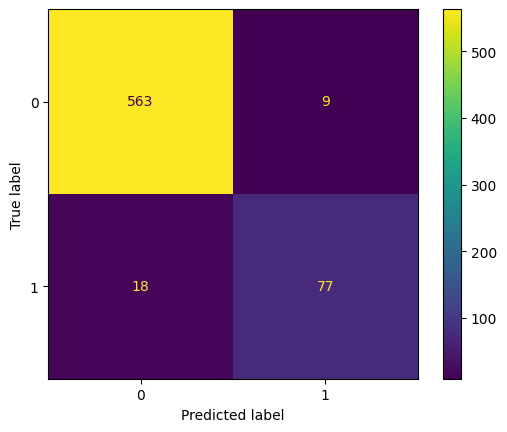

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test_final, y_pred_meta)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [44]:
print(classification_report(y_test_final, y_pred_meta))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       572
           1       0.90      0.81      0.85        95

    accuracy                           0.96       667
   macro avg       0.93      0.90      0.91       667
weighted avg       0.96      0.96      0.96       667



In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba_meta)
fig = px.line(x=fpr,y=tpr,
        title="ROC Curve of Final LGBM Model"
              )

fig.update_layout(xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",)

fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tozeroy',name=f"AUC: {model_performance_final["roc_auc_score"]:.2f}"))
fig.show()

## Feature Importance - SHAP Plot

In [46]:
print(X_train_final.columns)

print(X_test_final.columns)

Index(['account_length', 'international_plan', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'intl_charge_per_min', 'total_minutes', 'total_calls',
       'daytime_charge_per_min', 'avg_charge_per_acc_day',
       'voicemail_engagement_lvl', 'customer_service_freq_lvl'],
      dtype='object')
Index(['account_length', 'international_plan', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'intl_charge_per_min', 'total_minutes', 'total_calls',
       'daytime_charge_per_min

In [47]:
print(X_train_meta.shape)

print(X_test_meta.shape)

(2666, 3)
(667, 3)


In [48]:
cv_split

<generator object _BaseKFold.split at 0x000002A235835250>

In [49]:
cv.split(X_train_final, y_train_final)

<generator object _BaseKFold.split at 0x000002A232631470>

In [50]:
n = 0

for i, (train_index, val_index) in enumerate(cv_split):
    if i <=n:
        X_train_base, X_val_base = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
        y_train_base, y_val_base = y_train_final.iloc[train_index], y_train_final.iloc[val_index]
    else:
        break

print(X_train_base.shape)
print(X_val_base.shape)
print(X_train_base.index[:5])

(2132, 22)
(534, 22)
Index([0, 3, 4, 5, 7], dtype='int64')


In [51]:
X_train_base.columns

Index(['account_length', 'international_plan', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'intl_charge_per_min', 'total_minutes', 'total_calls',
       'daytime_charge_per_min', 'avg_charge_per_acc_day',
       'voicemail_engagement_lvl', 'customer_service_freq_lvl'],
      dtype='object')

In [52]:
for model_name in ['lgbm', 'xgb', 'cb']:
    print(f"SHAP summary plot for base model: {base_best_model[model_name]}")

SHAP summary plot for base model: LGBMClassifier(colsample_bytree=0.9561347875507571, max_depth=4,
               min_child_weight=5, n_estimators=112, random_state=42,
               reg_alpha=1, reg_lambda=0, scale_pos_weight=5.871134020618556)
SHAP summary plot for base model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9910955972619857, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05019049103849115,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=138, 

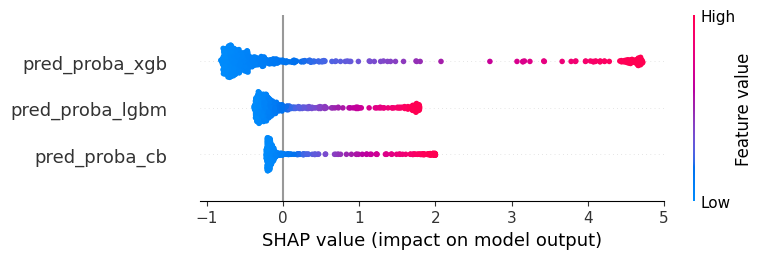

SHAP summary plot for base model: xgb


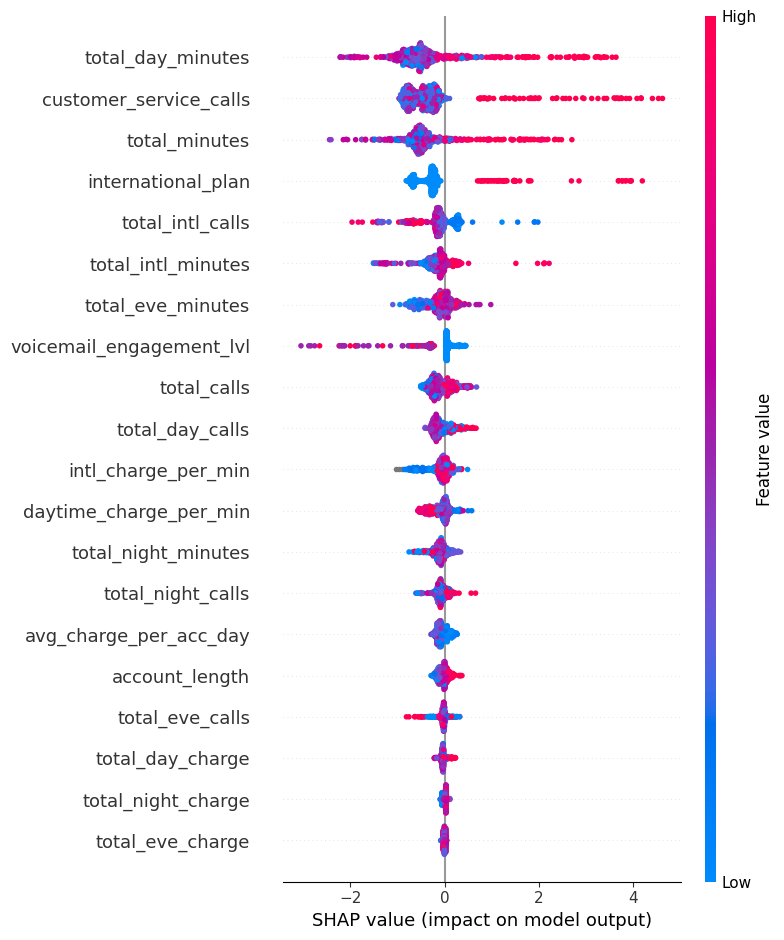

SHAP summary plot for base model: lgbm


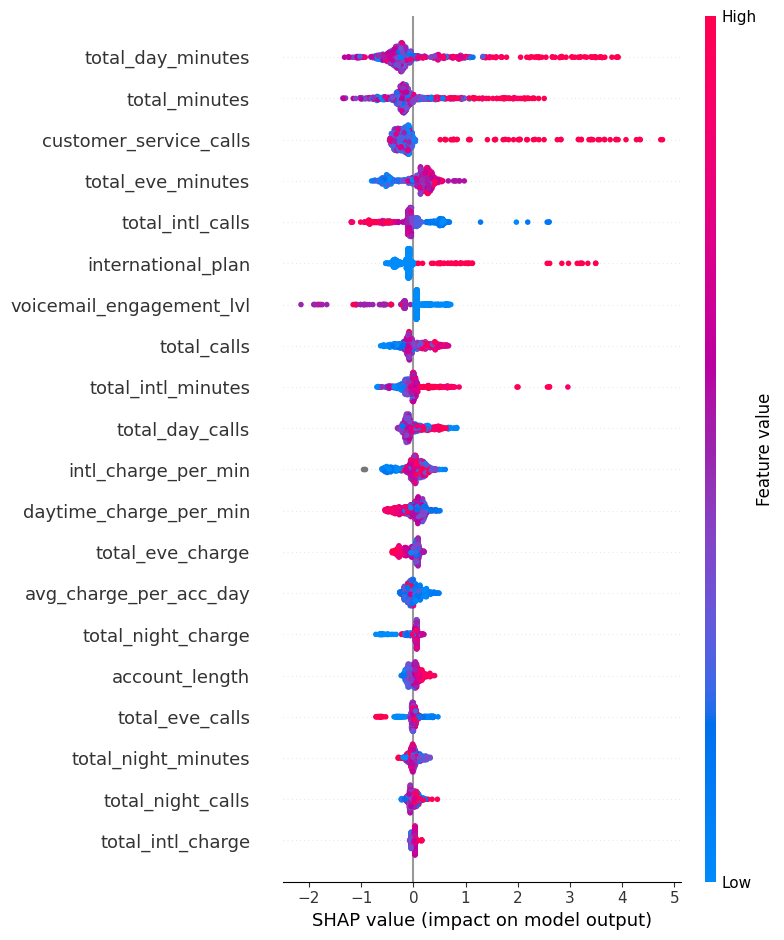

SHAP summary plot for base model: cb


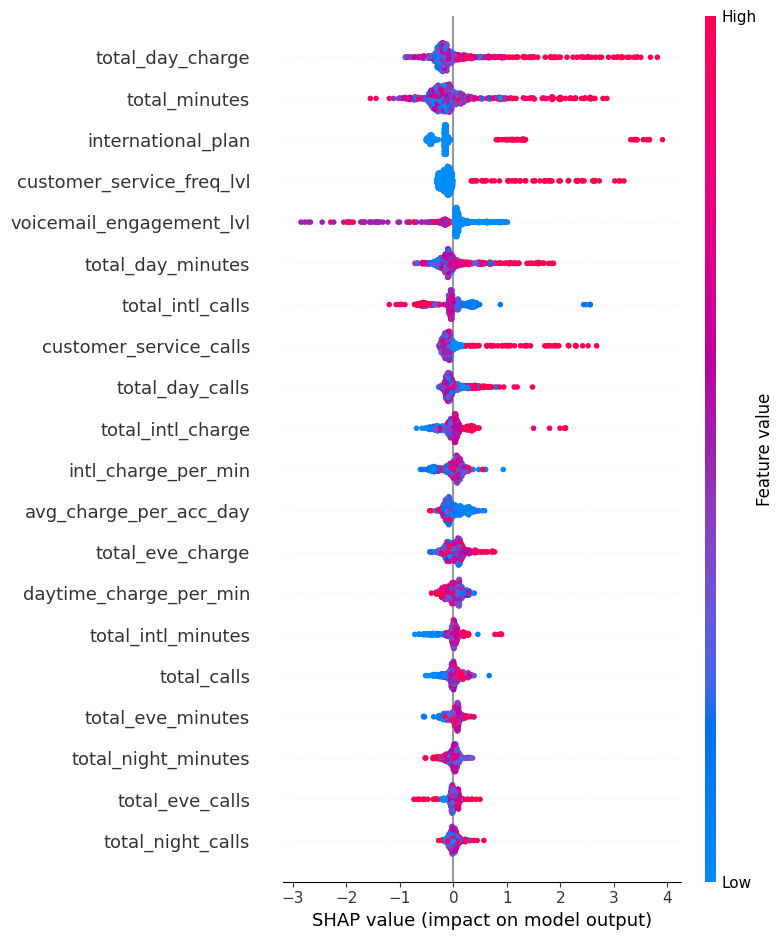

In [62]:
import shap

# SHAP for the Meta-Model
meta_explainer = shap.Explainer(meta_model, X_train_meta)
shap_values_meta = meta_explainer(X_test_meta)
shap.summary_plot(shap_values_meta, X_test_meta)

# SHAP for the Base Models
for model_name in ['xgb', 'lgbm', 'cb']:
    print(f"SHAP summary plot for base model: {model_name}")
    shap_values = shap.TreeExplainer(base_best_model[model_name]).shap_values(X_test_final)
    shap.summary_plot(shap_values, X_test_final)